In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
resp_sofa = [
    'sofa_resp_day1',
    'sofa_resp_day2',
    'sofa_resp_day3'
]

def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['sofa_resp_baseline'] == 0]


    # design_matrix['sofa_resp_diff2'] = design_matrix['sofa_resp_day2'] - design_matrix['sofa_resp_baseline']
    # design_matrix['sofa_resp_diff3'] = design_matrix['sofa_resp_day3'] - design_matrix['sofa_resp_baseline']
    # design_matrix['sofa_resp_diff1'] = design_matrix['sofa_resp_day1'] - design_matrix['sofa_resp_baseline']

    design_matrix['max_resp_diff'] = np.max(
        design_matrix[
            [
                'sofa_resp_day1', 
                'sofa_resp_day2', 
                'sofa_resp_day3'
            ]
        ], 
        axis=1
    )

    design_matrix = design_matrix[
        (design_matrix['max_resp_diff'] == 0.0) |
        (design_matrix['max_resp_diff'] > 2.0)
    ].copy()

    design_matrix['group'] = np.where(
        design_matrix['max_resp_diff'] > 0, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     


# Model Training

In [4]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [5]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [6]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

/tmp/ipykernel_1034359/1352007829.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['max_resp_diff'] = np.max(


<Axes: xlabel='max_resp_diff', ylabel='Count'>

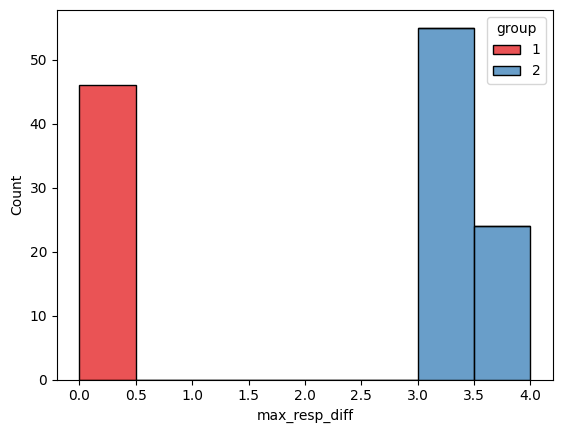

In [7]:
sns.histplot(
    design_matrix_train,
    x="max_resp_diff",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [8]:
design_matrix_train['group'].value_counts()

group
2    79
1    46
Name: count, dtype: int64

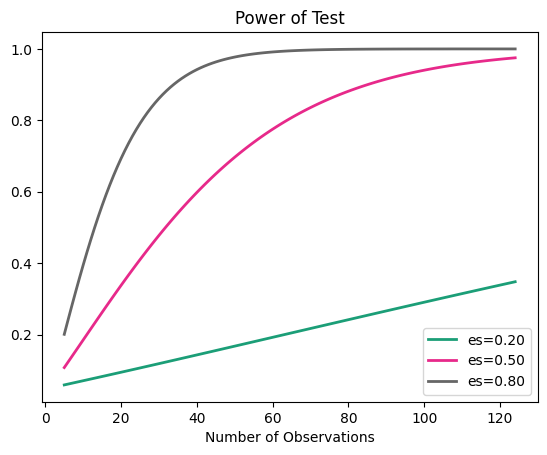

In [9]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [10]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [11]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [12]:
quant_matrix_train.write("de_results/resp_de_proteins.tsv")

In [13]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

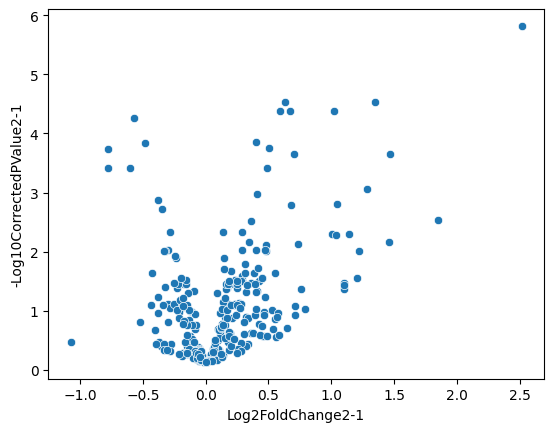

In [14]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [15]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [16]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [17]:
protein_columns = training_data.columns.to_list()

In [18]:
len(protein_columns)

287

In [19]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf
# )

In [21]:
from cleanlab.filter import find_label_issues
from sklearn.model_selection import cross_val_predict

pred_probs = cross_val_predict(protein_clf, X, y.values.ravel(), cv=3, method="predict_proba")

label_issues = find_label_issues(
    labels=y.values.ravel(),
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence',  # Ranks by likelihood of being mislabeled
)

/srv/data1/home/aaron/envs/miniconda3/envs/revisionenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# label_issues

In [23]:
mask = np.ones(len(y.values.ravel()), dtype=bool)

mask[label_issues] = False

In [24]:
# mask.shape

In [25]:
X = X.iloc[mask, :].copy()
y = y.iloc[mask, :].copy()

In [26]:
y['label'].value_counts()

label
1    69
0    33
Name: count, dtype: int64

In [27]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 1.5454545454545454, 1: 0.7391304347826086}

In [28]:
sample_weight = compute_sample_weight(
    class_weight=class_weight,
    y=y.values.ravel()
)

In [29]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


In [30]:
selected_proteins

['PSPB_HUMAN',
 'NCAM1_HUMAN',
 'PCSK9_HUMAN',
 'IBP2_HUMAN',
 'COIA1_HUMAN',
 'ALS_HUMAN',
 'TSP1_HUMAN',
 'VWF_HUMAN',
 'CYTC_HUMAN',
 'FBLN5_HUMAN',
 'IBP3_HUMAN',
 'FBLN3_HUMAN',
 'TIMP1_HUMAN',
 'RS27A_HUMAN',
 'CNDP1_HUMAN',
 'RNAS1_HUMAN',
 'FETUA_HUMAN',
 'B2MG_HUMAN',
 'PCOC1_HUMAN',
 'LYSC_HUMAN',
 'PON1_HUMAN',
 'TENA_HUMAN',
 'IBP7_HUMAN',
 'ENOA_HUMAN',
 'FETUB_HUMAN',
 'NRP1_HUMAN',
 'HSP7C_HUMAN',
 'AACT_HUMAN',
 'CO7_HUMAN',
 'THBG_HUMAN',
 'SODC_HUMAN',
 'CALR_HUMAN',
 'MRC1_HUMAN',
 'APOL1_HUMAN',
 'CMGA_HUMAN',
 'CFAB_HUMAN',
 'TETN_HUMAN',
 'CFAD_HUMAN',
 'ITIH3_HUMAN',
 'A1AT_HUMAN',
 'BIP_HUMAN',
 'CATB_HUMAN',
 'FIBA_HUMAN',
 'C163A_HUMAN',
 'PTPRG_HUMAN',
 'APOC4_HUMAN',
 'VCAM1_HUMAN',
 'APOM_HUMAN',
 'PLTP_HUMAN',
 'VSIG4_HUMAN']

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [32]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.9420289855072465,
 0.9285375494071145,
 0.9117647058823529,
 0.8952569169960475)

In [33]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [34]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [35]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [36]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
0,PSPB_HUMAN,1.000000,1.0,0.903007,2.0,0.509618,11.0,1.000000,1.0,0.536939,...,0.518919,10.0,0.782668,6.0,0.848777,0.953907,0.182253,3.46,2.0,3.983349
13,RS27A_HUMAN,0.234021,25.0,0.543689,14.0,0.838058,4.0,0.500576,6.0,1.000000,...,0.822365,5.0,0.489795,16.0,0.541217,0.504508,0.285682,13.70,9.0,12.890761
6,TSP1_HUMAN,0.220628,26.0,1.000000,1.0,1.000000,1.0,0.453186,7.0,0.499901,...,0.725700,6.0,0.645933,8.0,0.538908,0.540343,0.260810,12.54,8.0,11.845316
14,CNDP1_HUMAN,0.372637,15.0,0.758575,9.0,0.461245,13.0,0.542353,3.0,0.460270,...,0.353900,20.0,0.588496,12.0,0.537925,0.538104,0.242998,11.58,10.0,9.501919
29,THBG_HUMAN,0.275161,19.0,0.832497,3.0,0.908278,3.0,0.524801,4.0,0.374333,...,1.000000,1.0,0.829727,2.0,0.505908,0.458364,0.305501,14.81,9.0,13.596416
36,TETN_HUMAN,0.726278,3.0,0.780980,6.0,0.600588,9.0,0.359147,9.0,0.507354,...,0.606398,8.0,0.803366,3.0,0.493242,0.483979,0.218867,12.61,9.5,8.852204
20,PON1_HUMAN,0.622205,5.0,0.262394,33.0,0.912679,2.0,0.062319,42.0,0.236677,...,0.876968,3.0,0.521629,15.0,0.491727,0.460349,0.275424,15.21,13.0,12.817519
4,COIA1_HUMAN,0.442692,10.0,0.792734,5.0,0.372628,19.0,0.281965,13.0,0.371404,...,0.681138,7.0,0.356821,30.0,0.464479,0.458759,0.178267,13.45,11.0,8.207382
3,IBP2_HUMAN,0.275113,20.0,0.410466,22.0,0.746100,6.0,0.502461,5.0,0.512989,...,0.309467,21.0,0.368436,29.0,0.461147,0.418329,0.192759,14.33,13.0,8.584759
1,NCAM1_HUMAN,0.678969,4.0,0.010141,49.0,0.434837,16.0,0.225349,21.0,0.297562,...,0.227169,29.0,0.800191,4.0,0.460558,0.405720,0.251118,15.68,12.0,11.817535


In [37]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [38]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [39]:
selected_features = selected_proteins[:10]

In [40]:
for feature in selected_features:

    print(feature)

PSPB_HUMAN
RS27A_HUMAN
TSP1_HUMAN
CNDP1_HUMAN
THBG_HUMAN
TETN_HUMAN
PON1_HUMAN
COIA1_HUMAN
IBP2_HUMAN
NCAM1_HUMAN


In [41]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [42]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.9710144927536232,
 0.9571256038647343,
 0.9509803921568628,
 0.9400527009222661)

In [43]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.9565217391304347,
 0.9317765567765569,
 0.9215686274509803,
 0.9025032938076416)

In [44]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
    
)

In [45]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [46]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [47]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
0,PSPB_HUMAN,1.000000,1.0,1.000000,1.0,0.705840,5.0,1.000000,1.0,0.937216,...,0.129472,9.0,0.677319,6.0,0.835345,0.948677,0.229570,2.70,2.0,2.346284
8,IBP2_HUMAN,0.500302,6.0,0.474717,5.0,0.855428,3.0,0.896669,2.0,0.705561,...,1.000000,1.0,1.000000,1.0,0.706482,0.706899,0.223039,3.69,4.0,1.926398
7,COIA1_HUMAN,0.874499,2.0,0.676393,2.0,0.617193,6.0,0.704467,3.0,0.605198,...,0.883668,2.0,0.693605,5.0,0.673391,0.687919,0.230301,4.05,4.0,2.109981
1,RS27A_HUMAN,0.620912,4.0,0.422889,8.0,0.593400,7.0,0.499074,5.0,1.000000,...,0.806498,4.0,0.935809,3.0,0.617936,0.586801,0.256590,4.79,5.0,2.555624
2,TSP1_HUMAN,0.244232,8.0,0.636739,3.0,1.000000,1.0,0.678313,4.0,0.474933,...,0.815441,3.0,0.549622,7.0,0.602772,0.604977,0.244002,4.85,5.0,2.417842
6,PON1_HUMAN,0.518378,5.0,0.011558,9.0,0.429684,8.0,0.016880,10.0,0.230109,...,0.762894,6.0,0.948853,2.0,0.473625,0.464396,0.280405,6.12,6.0,2.697848
4,THBG_HUMAN,0.204662,9.0,0.444882,7.0,0.886462,2.0,0.206595,8.0,0.435293,...,0.798883,5.0,0.740448,4.0,0.413976,0.368525,0.256404,6.87,7.5,2.484924
3,CNDP1_HUMAN,0.170213,10.0,0.460848,6.0,0.249792,9.0,0.422479,7.0,0.569033,...,0.304691,8.0,0.454670,9.0,0.407741,0.377603,0.218478,6.70,7.0,2.367712
5,TETN_HUMAN,0.757318,3.0,0.507973,4.0,0.776038,4.0,0.492834,6.0,0.567002,...,0.323526,7.0,0.547207,8.0,0.377940,0.349778,0.238379,7.13,8.0,2.646343
9,NCAM1_HUMAN,0.377281,7.0,0.000978,10.0,0.089939,10.0,0.134134,9.0,0.185464,...,0.066999,10.0,0.401678,10.0,0.275986,0.259291,0.175818,8.10,9.0,1.920122


In [48]:
final_protein_importances.to_csv(
    "feature_importances/resp_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [49]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [50]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [51]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [52]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [53]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [54]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [55]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

decision_tree = DecisionTreeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)



# lr_clf = GradientBoostingClassifier(
#     #estimator=random_forest,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)




In [56]:
lr_clf.fit(X[selected_features], y.values.ravel()) #sample_weight=sample_weight)
xgb_clf.fit(X[selected_features], y.values.ravel(), sample_weight=sample_weight)
decision_tree.fit(X[selected_features], y.values.ravel(), sample_weight=sample_weight) 
random_forest.fit(X[selected_features], y.values.ravel(), sample_weight=sample_weight)
svc.fit(X[selected_features], y.values.ravel(), sample_weight=sample_weight)
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), sample_weight=sample_weight) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [57]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [58]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.8333333333333334,
 0.8301886792452831,
 0.7643312101910829,
 0.8809523809523809,
 0.8104575163398693,
 0.8402366863905325,
 0.8,
 0.8553459119496856)

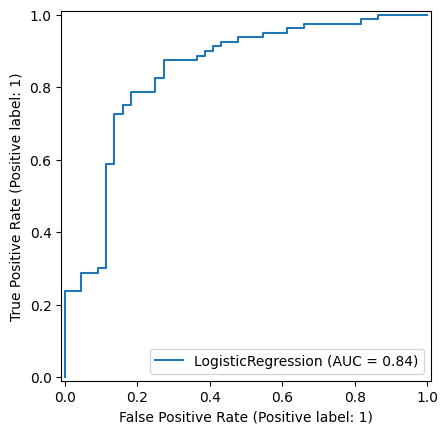

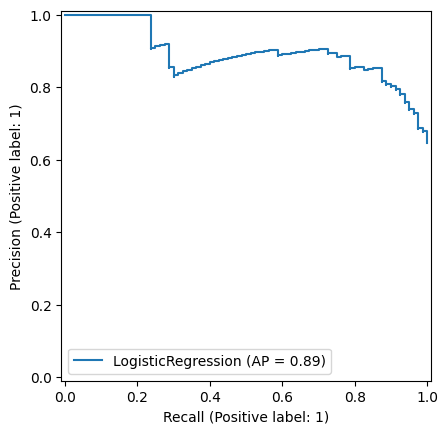

In [59]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [60]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [61]:
roc_df.to_csv(
    "roc/respiratory.tsv",
    sep="\t"
)

# Probability Prediction

In [62]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)#.impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [63]:
predict_data = predict_data[protein_columns].copy()

In [64]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [65]:
predict_data['resp_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [66]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['resp_probability']
).reset_index()

In [67]:
predict_data[['resp_probability']].to_csv(
    "predictions_test/respiratory.tsv",
    sep="\t"
)

<Axes: xlabel='resp_probability', ylabel='Count'>

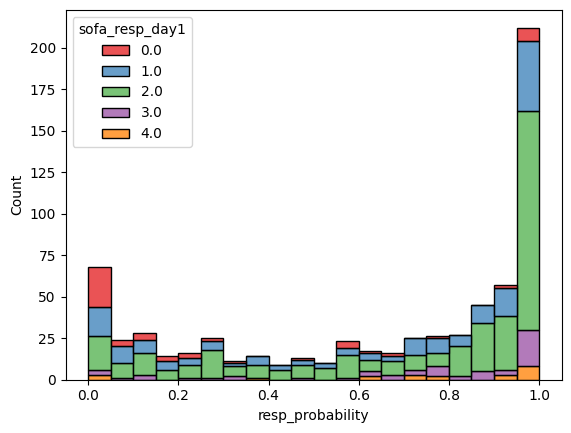

In [68]:
sns.histplot(
    data=design_matrix_test,
    x="resp_probability",
    hue="sofa_resp_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [69]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [70]:
val_data = val_data[protein_columns].copy()

In [71]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [72]:
val_data['resp_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [73]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['resp_probability']
).reset_index()

In [74]:
val_data[['resp_probability']].to_csv(
    "predictions_val/respiratory.tsv",
    sep="\t"
)

<Axes: xlabel='resp_probability', ylabel='Count'>

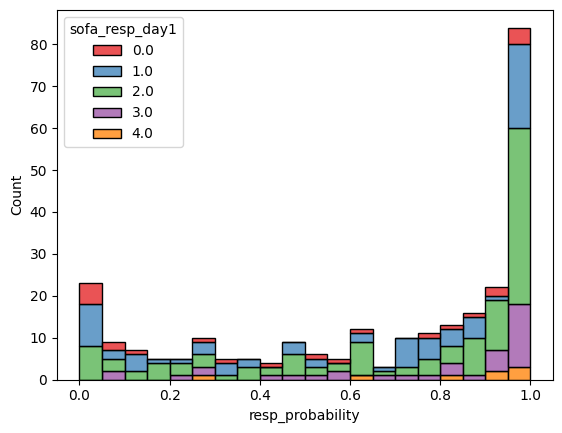

In [75]:
sns.histplot(
    data=design_matrix_val,
    x="resp_probability",
    hue="sofa_resp_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [76]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [77]:
hero_data = hero_data[protein_columns].copy()

In [78]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [79]:
hero_data['resp_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [80]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['resp_probability']
).reset_index()

In [81]:
hero_data[['resp_probability']].to_csv(
    "predictions_external/respiratory.tsv",
    sep="\t"
)

<Axes: xlabel='resp_probability', ylabel='Count'>

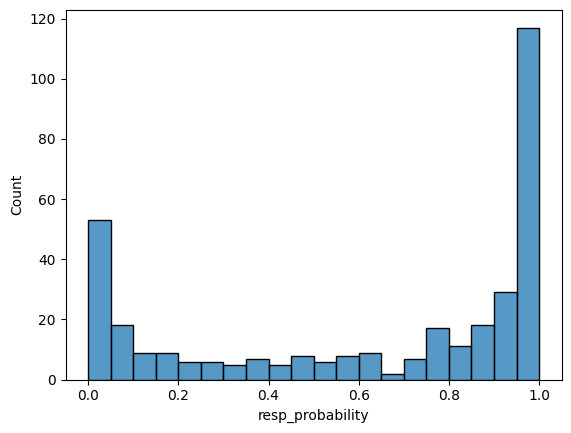

In [82]:
sns.histplot(
    data=hero_data,
    x="resp_probability",
    #hue="sofa_resp_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [83]:
from joblib import dump


with open("models/resp_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/resp_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
